### Import for days!
Let's pull all of the libraries we'll need  for the project

In [1]:
# will this ever be used... the world will never know
import tensorflow as tf

import math

# scrape wiki plaintext
import wikipedia

# to view word freq dist
import matplotlib.pyplot
import tkinter

# store the articles so we don't annoy wikipedia (TODO)
# (might change to database storage later)
import _pickle as cPickle

# trying database storage :)!
import sqlite3

# make pretty progress bars
from tqdm import tnrange, tqdm_notebook
from time import sleep

# commonly used words...
import re
import os.path
import urllib.request

from stop_words import get_stop_words
import nltk.tokenize.punkt
import nltk.data

from nltk.corpus import stopwords



### Let's get a list of common words and put them in one list/set

__Todo__
* Try Different sizes of the set (only top 1,000 stop words?)

In [2]:
nltk.download("stopwords")
nltk.download("punkt")

test = stopwords.words('english')

common_words = get_stop_words(language='english', cache=True)

fn = '10k_common.txt'

# wow, so ethical!
if os.path.isfile(fn):
    print("already downloaded the common words list")
    myfile = open(fn, 'r')
    most_common = [line for line in myfile.readlines()]
else:
    print('Let me download that common word list file for you!')
    url = 'https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-usa.txt'
    urllib.request.urlretrieve(url, filename=fn)
    myfile = open(fn, 'r')
    most_common = [line.strip() for line in myfile.readlines()]
   
# Awesome, concat_list contains all of the unique common words

concat_list = list(set(s.lower().strip() for s in test + common_words + most_common))

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
already downloaded the common words list


### Now let's download a wiki article

__TO DO:__
* make a local article caching system

In [3]:
my_topic = "karhunen-loeve theorem"

article = wikipedia.page(title=my_topic,  auto_suggest=True, redirect=True, preload=False)

# article.content is text of info on the page
# article.link is a list of links
# for more info go here: https://pypi.python.org/pypi/wikipedia/

print("\n===================\nSuccessfully downloaded wiki article(",\
      my_topic ,  ")\n===================\n __SAMPLE__:\n",article.content[0:100],"...")


Successfully downloaded wiki article( karhunen-loeve theorem )
 __SAMPLE__:
 In the theory of stochastic processes, the Karhunen–Loève theorem (named after Kari Karhunen and Mic ...


### Do some processesing on the article

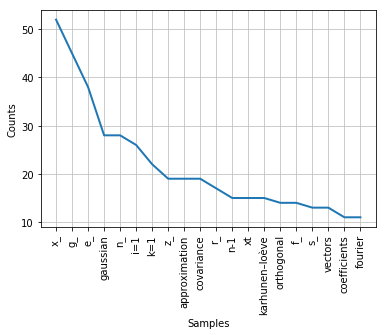


The top 20 uncommon words in the article on karhunen-loeve theorem are: 

('x_', 52) 

('g_', 45) 

('e_', 38) 

('n_', 28) 

('gaussian', 28) 

('i=1', 26) 

('k=1', 22) 

('approximation', 19) 

('covariance', 19) 

('z_', 19) 

('r_', 17) 

('n-1', 15) 

('xt', 15) 

('karhunen–loève', 15) 

('f_', 14) 

('orthogonal', 14) 

('s_', 13) 

('vectors', 13) 

('coefficients', 11) 

('fourier', 11) 



In [4]:
#break the article up by sentence

sentence_detection = nltk.data.load('tokenizers/punkt/english.pickle')

#print('\n ... \n '.join(sentence_detection.tokenize(article.content.strip())))


tokens = nltk.word_tokenize(article.content)

must_contain_some_letters = re.compile("[a-zA-Z]+") # assuming corpus is latin alphabet (can update this assumption later)

words = [w.lower() for w in tokens]

# remove "words" that are only comprised of symbols and numbers only
words = list(filter(must_contain_some_letters.match, words))

# remove stop words
words = [w for w in words if w not in concat_list]


fd = nltk.FreqDist(words) 
n = 20
fd.plot(n, cumulative=False) 



# sorts the most frequent words
top_n_best_words_omg = []
for w in set(words):
    top_n_best_words_omg.append((w, words.count(w)))

top_n_best_words_omg.sort(key=lambda x: x[1], reverse=True)
# sort by the second element in the tuple

print("\n===================\nThe top", n ,"uncommon words in the article on" , my_topic, "are: \n===================\n")
for i in range(n):
    print(top_n_best_words_omg[i],"\n")


### Found a pretrained model called Glove on the internets (it's a very large word embedding model)

Simply put, word embeddings are numeric vector representations of words.

An example of this would be -- let the word "apple" be represented by the vector [1,0] and let every other word be represented by [0,1].

Although this is a word embedding, clearly, we can do better.

To read more about how Glove is fit to the data ;) go to [stanford ...'s website](https://nlp.stanford.edu/projects/glove/)


### GLOVE IS HUGE (~6gig text file)

So we're going to store it in an sqlite3 database!

__TODO__:
* write helper functions for database: enter (unique) data, extract data


In [5]:
# Database helper function
def table_exists(connection, table_name):
    cur = connection.cursor()
    table_name = (table_name,)
    cur.execute('SELECT COUNT(*) from sqlite_master where type = \'table\' and name = ? ', table_name )
    result = cur.fetchone()
    return result[0] == 1

In [6]:
# table information

sqlite_file = 'word_embedding_project.sqlite'

# table info must be a list of tuples containing column name and type

table1_name = 'glove_word_embeddings'
table1_info = [('word','VARCHAR(50)')\
              ,('embedding','VARCHAR(3000)')]

table2_name = 'wiki_articles'
table2_info = [('title','content')]

In [12]:
def open_database(file_name):
    connection = sqlite3.connect(file_name)
    return connection

def close_database(connection):
    connection.close()


def create_table(file_name, table_name, list_of_tuple_column_name_type):
    if table_exists(file_name,table_name):
        print("table \'{}\' already exists, carrying on".format(table_name))
    else :
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        #print("------------------\nopened...", table_name)
        
        exe = 'CREATE TABLE ' + table_name + ' (' + ', '.join([i[0] +\
            ' ' +  i[1] for i in list_of_tuple_column_name_type]) + ' )'

        #print('\n :: sending SQL :: ' + exe + '\n')     
        
        c.execute('{}'.format(exe) )
        connection.close()
        #print("closed...", table_name, "\n------------------\n")

def get_column_names(connection,table_name):
        c = connection.cursor()
        #print("------------------\nopened table:", table_name)
        
        exe = 'PRAGMA TABLE_INFO({})'.format(table_name)
        
        #print('\n :: sending SQL :: ' + exe + '\n')     
        c.execute('{}'.format(exe) )
        # result is a tuple, result[1] contains the table name
        names = [result[1] for result in c.fetchall()]
        
        #print("closed table: ", table_name , "\n------------------\n")
        return names
        
def insert_data(connection,table_name,list_of_tuple_data,\
                 unique_column_name):
        c = connection.cursor()
        #print("------------------\nopened...", connection)
        # somewhere in here we will check to see that the data is unique
        column_names = get_column_names(file_name,table_name)
        index_of_unique_column = column_names.index(unique_column_name)
        check_this_data = [i[index_of_unique_column] for i in list_of_tuple_data]
        
        my_unique_data = get_unique(file_name,table_name,check_this_data,unique_column_name)
        
        #print(my_unique_data)
        
        #add_these contains the unique entries that we'll add to the database!
        add_these = [i for i in list_of_tuple_data if my_unique_data.count(i[index_of_unique_column]) == 1]
        
        list_of_tuple_data = add_these
        
        if len(add_these) > 0:
            num_question_marks = len(list_of_tuple_data[0])
            exe = 'INSERT INTO ' + table_name + ' VALUES (' +\
            ','.join(['?' for i in range(num_question_marks)]) + ')'

            #print('\n :: sending SQL :: ' + exe + '\n')     

            c.executemany('{}'.format(exe),list_of_tuple_data )
            connection.commit()
        else:
            a = 1
            #print("nothing new to add :(")
        
        #print("closed...\n------------------\n", table_name)
        

def get_unique(connection,table_name,list_of_data, unique_column):
        unique_list_of_tuple_data = []
        
        c = connection.cursor()
        
        for i in list_of_data:
            exe = 'SELECT count(*) FROM ' + table_name + ' WHERE ' + unique_column + ' = \'' + i +'\''
            #print('\n :: sending SQL :: ' + exe + '\n') 
            c.execute('{}'.format(exe))
            if c.fetchone()[0] > 0 :
                a = 1
                #print("The data:\'"  + i + "\' already exists in the database")
            else :
                #print("Adding data: ", i , " to database")
                unique_list_of_tuple_data.append(i) 
        
        return unique_list_of_tuple_data

def print_stored(connection,file_name,table_name):
        c = connection.cursor()
        #print("------------------\nopened...", connection)

        exe = 'SELECT * FROM ' + table_name 
        #print('\n :: sending SQL :: ' + exe + '\n')     
        
        for row in c.execute('{}'.format(exe)):
            print(row)
        
        #print("closed...\n------------------\n", table_name
        



In [8]:

create_table(sqlite_file,table1_name,table1_info)

#create_table(sqlite_file,table2_name,table2_info)


"""insert_data(sqlite_file,table1_name,[('test_word1','embedding_00001')\
                                    ,('test_word2','embedding_00002')\
                                    ,('test_word3','embedding_00003')],\
           'word')
"""
#print_stored(sqlite_file,table1_name)

# get_unique(sqlite_file,table1_name,['test_word1','test_word2','test_word_3'],unique_column='word')

num_lines = None

__TODO__
* extract the embeddings of the common words dataset
* do tsne on the embeddings


## Now that we have some database helper functions, let's insert the glove embeddings into the database

In [13]:
#as it stands this ran all night on just 1 gig of data... 
# I need to implement some of the speed up techniques mentioned:
# here: https://stackoverflow.com/questions/1711631/improve-insert-per-second-performance-of-sqlite

error_buffer = []

import re
import time
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py

batch_size = 100 # insert this many words at a time into the database (play around with different numbers)
file_name = 'glove.840B.300d.txt'
error_file = 'errors.txt'

connection = open_database(sqlite_file)

#KEEP TRACK OF INSERTS/SECOND
start = time.time()
record_of_ops_per_second = []

alphabet = re.compile(r"^[a-zA-Z]+$")

error_buffer = []
buffer = []
with open(file_name,"r") as fn:
    for line in fn:
        
        #GET RID OF THIS LINE LATER!!!
        error_buffer = []
        
        
        if (len(buffer) != 0) & (len(buffer) % batch_size == 0):
            insert_data(connection,table1_name,buffer,'word')
            new_time = time.time()
            duration = new_time - start
            start = new_time
            record_of_ops_per_second.append(batch_size/duration)
            buffer = []
    
        split_line = line.split(" ",1)
        word = split_line[0]
        
        if alphabet.match(word) == None :
            error_buffer.append(line)
            #print("need alphabet chars! just look at this so called 'word': ", word)
            """with open(error_file,"a") as ef:
                #print("oh nooooo, errrrror")
                #print(word + embedding)
                ef.write(word + " " + embedding)
                ef.close()"""
        else :
            #print("Now this is a proper word: ", word)
            embedding_split = split_line[1].split(" ")
            embedding = split_line[1]
            if (len(embedding_split) == 300):
                buffer.append((word, embedding))
                #print("appended:" + word + "\nbuffer now has " + str(len(buffer)) + " elements in it.")
            else:
                error_buffer.append(line)
"""with open(error_file,"a") as ef:
                    #print("oh nooooo, errrrror")
                    #print(word + embedding)
                    ef.write(word + " " + embedding)
                    ef.close()"""

if (len(buffer) != 0):
    insert_data(connection,table1_name,buffer,'word')
    buffer = []
    
close_database(connection)

AttributeError: 'str' object has no attribute 'cursor'

[-4904.012720980264, -2307.9484738600036, -2255.4872015487203, -2039.0492904681112, -2764.4301494819542, -1050.1617442337931, -1106.2591159536112, -855.3223336331027, -681.1024811183951, -424.41859170834823, -440.81198534937124, -420.7891280946175, -341.50981342083514, -436.82885652659786, -449.0420274587391, -490.40757936976553, -466.44943605301614, -416.8206856869142, -393.458222718361, -358.6613341679258, -352.13405982654837, -350.4379321148825, -291.3546732500363, -318.6710692865598, -323.3606096069842, -306.12005984746196, -246.12683474138896, -281.6511592926059, -219.13012585746603, -236.6916583806137, -253.16273550455648, -210.177590699539, -220.4303177456143, -230.28784992952956, -231.54720730916267, -178.4609728949599, -204.24749457035168, -216.52759107025227, -210.70720954252621, -181.3509972717171, -202.02433556921554, -200.02279541402052, -186.75897371048134, -187.11840694099195, -175.96221575498637, -176.46221840770588, -176.77689203735562, -169.7079163773668, -174.0315889

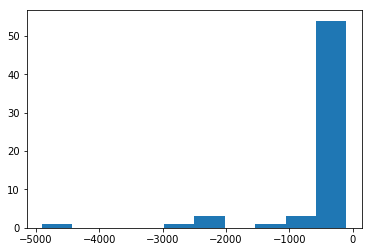

In [11]:
#plot the ops/second over timej
%matplotlib inline


plt.hist(record_of_ops_per_second)
fig = plt.gcf()